## Диагностика сердечно-сосудистых заболеваний

Целью даного проекта является построение модели способной ставить предварительный  диагноз о наличии  заболеваний сердечнососудистой системы пациента на основании ряда анализов. Истоник: https://www.kaggle.com/ronitf/heart-disease-uci

## Шаг 1. Загрузка данных

In [1]:
# Импортируем необходимые для дальнейшего анализа данных библиотеки

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import random

In [3]:
# Импортируем необходимые для ML библиотеки

In [4]:
import catboost
print(catboost.__version__)
!python --version

from catboost import CatBoostClassifier, Pool, cv
from catboost.utils import get_roc_curve, get_fpr_curve, get_fnr_curve, \
select_threshold
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import tree
from sklearn.metrics import precision_score, plot_roc_curve, recall_score, \
roc_curve, auc, plot_confusion_matrix, accuracy_score

import shap

1.0.3
Python 3.8.5


In [5]:
# pip install ipywidgets

In [6]:
# !pip install --user --upgrade catboost
# !pip install --user --upgrade ipywidgets
# !pip install shap
# !pip install sklearn
# !pip install --upgrade numpy
# !jupyter nbextension enable --py widgetsnbextension

In [7]:
# импортируем библиотеку для создания нейронной сети. 
import torch

Обеспечим возобновляемость экспериментов, т.е зафиксируем случайность

In [8]:
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

In [9]:
df = pd.read_csv('heart.csv')

In [10]:
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


1. age - age in years
2. sex - (1 = male; 0 = female)
3. cp - chest pain type
- 0: Typical angina: chest pain related decrease blood supply to the heart
- 1: Atypical angina: chest pain not related to heart
- 2: Non-anginal pain: typically esophageal spasms (non heart related)
- 3: Asymptomatic: chest pain not showing signs of disease
4. trestbps - resting blood pressure (in mm Hg on admission to the hospital)
anything above 130-140 is typically cause for concern
5. chol - serum cholestoral in mg/dl
serum = LDL + HDL + .2 * triglycerides
above 200 is cause for concern
6. fbs - (fasting blood sugar > 120 mg/dl) (1 = true; 0 = false)
'>126' mg/dL signals diabetes
7. restecg - resting electrocardiographic results
- 0: Nothing to note
- 1: ST-T Wave abnormality
can range from mild symptoms to severe problems
signals non-normal heart beat
- 2: Possible or definite left ventricular hypertrophy
Enlarged heart's main pumping chamber
8. thalach - maximum heart rate achieved
9. exang - exercise induced angina (1 = yes; 0 = no)
10. oldpeak - ST depression induced by exercise relative to rest
looks at stress of heart during excercise
unhealthy heart will stress more
11. slope - the slope of the peak exercise ST segment
- 0: Upsloping: better heart rate with excercise (uncommon)
- 1: Flatsloping: minimal change (typical healthy heart)
- 2: Downslopins: signs of unhealthy heart
12. ca - number of major vessels (0-3) colored by flourosopy
colored vessel means the doctor can see the blood passing through
the more blood movement the better (no clots)
13. thal - thalium stress result
- 1,3: normal
- 6: fixed defect: used to be defect but ok now
- 7: reversable defect: no proper blood movement when excercising
14. target - have disease or not (1=yes, 0=no) (= the predicted attribute)

Выбирем категориальные численные  признаки

In [11]:
ctg_ftr = ['sex','cp','fbs','restecg','exang','slope','ca','thal']
num_ctg = [item for item in list(df.columns) if item not in ctg_ftr]
num_ctg.remove('target')
num_ctg

['age', 'trestbps', 'chol', 'thalach', 'oldpeak']

In [12]:
# Оценика содержание датафрейма
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    int64  
 12  thal      303 non-null    int64  
 13  target    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


<b> Вывод </b>

Для анализа представлен весьма ограниченный датасет с большим числом категориальных признаков значение которых верно может интерпритировать тольк оспециалист в области медицины. Типы признаков полностью соответствуют их характеру и в изменении не нуждаются.

## Шаг 2. Предобработка данных

In [13]:
#Найдем общее количество дубликатов
print('количество дубликатов:',df.duplicated().sum())

количество дубликатов: 1


In [14]:
#Удалим дубликаты, выполним проверку отсутствия дубликатов
df = df.drop_duplicates()
print('количество дубликатов:',df.duplicated().sum())

количество дубликатов: 0


In [15]:
# суммарное количество пропусков
df.isnull().sum() 

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64

Оценим разброс значений в численных признаках.

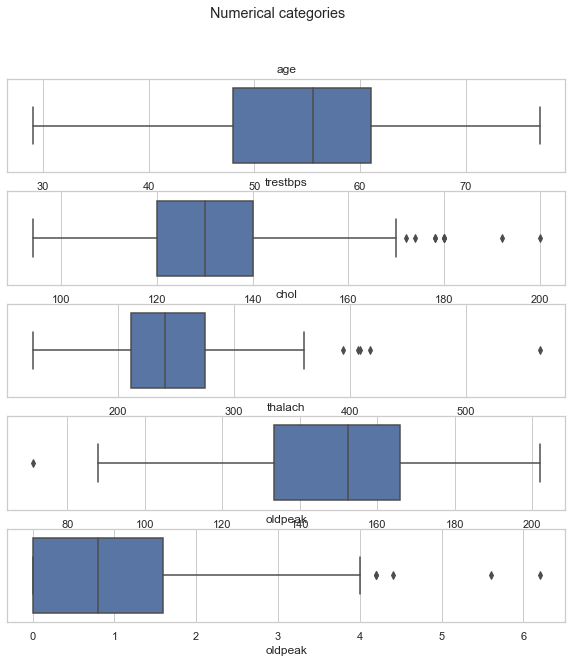

In [16]:
sns.set_theme(style="whitegrid")

fig, axes = plt.subplots(5, 1, figsize=(10, 10), sharey=True)
fig.suptitle('Numerical categories')

for i in range(len(num_ctg)):
    sns.boxplot(ax=axes[i], x=df[num_ctg[i]])
    axes[i].set_title(num_ctg[i])

Некоторые величины лежат за границами трех стандартных отклонений и следовательно могут быть отнесены к выбросам, однако все же их величины не являются экстремально большими и могут быть действительно признаками значительного отклонения в состоянии здоровья пациента.

Выделим признаки и целевой признак

In [17]:
raw_X = df.drop(['target'], axis = 1)
raw_y = df['target']

Посмотрим на распределение целевого признака

In [18]:
print('labels: {}'.format(set(raw_y)))
print('Zero count = {}, One count = {}'.format(len(raw_y) - sum(raw_y), sum(raw_y)))

labels: {0, 1}
Zero count = 138, One count = 164


Видим что данные хорошо сбалансированные, отношение 1 к 0 близко к 50%, а имеено составляет 54%. Следовательно не требуются мероприятия по устранению дисбаланса классов. 

## Шаг 2. Дерево решений

В качестве базовой модели (base line model) будем использовать дерево решений. Так как данная модель обладает интерпретируемой структурой, которая сопоставима с алгоритмом принятия решений которым пользуется специалист, т.е. человек. Таким образом построенная модель вполне может аналогом реального врача-кардиолога.

In [19]:
X_ohe = pd.get_dummies(raw_X, columns=ctg_ftr , drop_first=False)
y = raw_y.copy()

Примем drop_first=False так как в данном случае дерево решений моделирует модель мышления человека. Большенство людей не оперируют в своих логических построениях "отсутствующими" категориями.

In [20]:
X_ohe.head(3)

,age,trestbps,chol,thalach,oldpeak,sex_0,sex_1,cp_0,cp_1,cp_2,...,slope_2,ca_0,ca_1,ca_2,ca_3,ca_4,thal_0,thal_1,thal_2,thal_3
0,63,145,233,150,2.3,0,1,0,0,0,...,0,1,0,0,0,0,0,1,0,0
1,37,130,250,187,3.5,0,1,0,0,1,...,0,1,0,0,0,0,0,0,1,0
2,41,130,204,172,1.4,1,0,0,1,0,...,1,1,0,0,0,0,0,0,1,0


In [21]:
X_train_ohe, X_test_ohe, y_train, y_test = train_test_split(
X_ohe, y, test_size=0.25, random_state=42, stratify=y)

In [22]:
clf = tree.DecisionTreeClassifier()

Зададим диапозон параметров для кросс валидации

In [23]:
params = {
'max_depth':range(3,30,1),
'min_samples_leaf':range(1,8),
'min_samples_split':range(2,10,2),
'random_state': [42]    
}

In [24]:
grid_search_clf  = GridSearchCV(clf, params, cv = 5, verbose=1, n_jobs=-1)

In [25]:
grid_search_clf.fit(X_train_ohe, y_train)

Fitting 5 folds for each of 756 candidates, totalling 3780 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 464 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done 3699 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done 3780 out of 3780 | elapsed:    6.5s finished


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'max_depth': range(3, 30),
                         'min_samples_leaf': range(1, 8),
                         'min_samples_split': range(2, 10, 2),
                         'random_state': [42]},
             verbose=1)

In [26]:
grid_search_clf.best_params_

{'max_depth': 3,
 'min_samples_leaf': 5,
 'min_samples_split': 2,
 'random_state': 42}

In [27]:
best_clf = grid_search_clf.best_estimator_

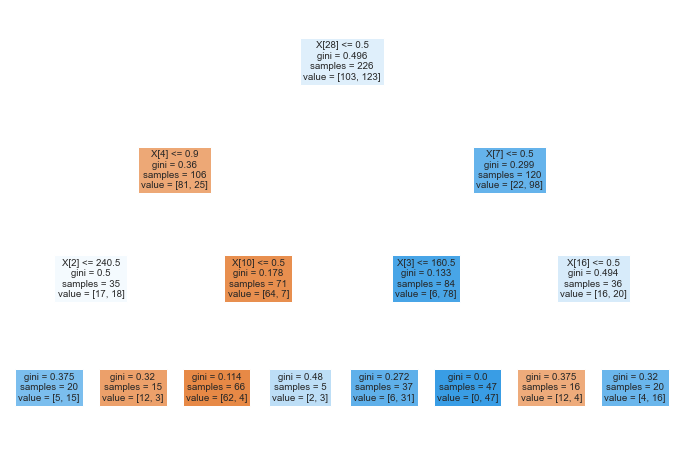

In [28]:
fig = plt.figure(figsize=(12,8))
tree.plot_tree(best_clf, filled=True)
fig.savefig("decistion_tree.png") # Выгрузим рисунок
plt.show()

In [29]:
y_pred = best_clf.predict(X_test_ohe)

Создадим функцию позволяющую получит основные метрики

In [30]:
def get_metrics(y_test, y_pred, print_metrics = True):
    model_precision = round(precision_score(y_test, y_pred, average='binary'), 4)
    model_recall = round(recall_score(y_test, y_pred), 4)
    model_acc = round(accuracy_score(y_test, y_pred), 4)
    if print_metrics:
        print('precision: ', model_precision, '\n'
          'recall: ', model_recall, '\n'
          'accuracy: ', model_acc)
    return model_precision, model_recall, model_acc

In [31]:
tree_precision, tree_recall, tree_acc = get_metrics(y_test, y_pred)

precision:  0.7 
recall:  0.8537 
accuracy:  0.7237


In [32]:
y_pred_prob = best_clf.predict_proba(X_test_ohe)

<AxesSubplot:>

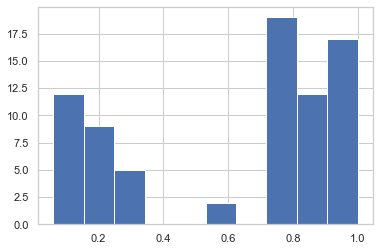

In [33]:
pd.Series(y_pred_prob[:, 1]).hist()

Вид распределения вероятностей предсказания класса показывает, отсутствие необходимости настраивать порог принятия решений.

In [34]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob[:,1])
roc_auc= auc(fpr, tpr)

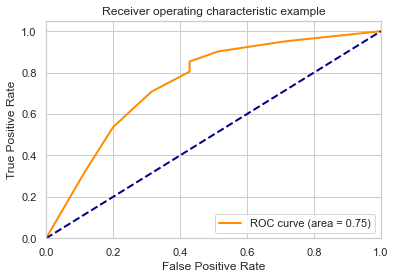

In [35]:
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw = 2,
         label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw= 2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

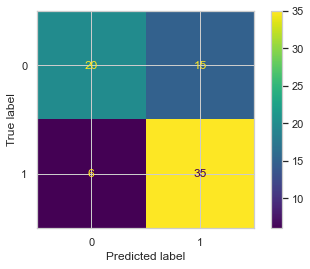

In [36]:
plot_confusion_matrix(best_clf, X_test_ohe, y_test)

#### Dummy model

Рассчитаем метрики в порядке эксперимента для dummy model в роли которой выбирем константную модель в которой всем пациентам был бы поставлен диагноз наличия сердечно-сосудистых заболеваний

In [37]:
y_dummy_pred = [1 for i in y_test]
dummy_precision, dummy_recall, dummy_acc = get_metrics(y_test, y_dummy_pred)

precision:  0.5395 
recall:  1.0 
accuracy:  0.5395


Таким образом смоделирована работа врача руководствующегося в постановке диагноза по ранее разработанным протоколам. Очевидна большая точность работы такой модели по сравнению с константным предсказанием, точность которой около 50% что является неприемлемым.

## Шаг 2. CatBoost 

In [38]:
# Создадим лист с индексами категориальных признаков.

In [39]:
# Повторим разделение на тренировочную и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(
raw_X, raw_y, test_size=0.25, random_state=42, stratify=raw_y)

In [40]:
cat_ftrs = list(map(lambda x: X_train.columns.get_loc(x), ctg_ftr))
cat_ftrs

[1, 2, 5, 6, 8, 10, 11, 12]

In [41]:
# MetricVisualizer(['learning_rate=0.5']).start() # отдельная визуализация процесса обучения

Сформируем пул для CatBoost

In [42]:
cat_pool = Pool(data=X_train, label=y_train, cat_features=cat_ftrs)

Для настройки модели на тренировочной выборке воспользуемся кросс валидацией

In [43]:
params = {}
params['loss_function'] = 'Logloss'
params['iterations'] = 60
params['custom_loss'] = ['AUC', 'Recall']
params['random_seed'] = 42
params['learning_rate'] = 0.2
params['early_stopping_rounds'] = 20

cv_data = cv(
    params = params,
    pool = cat_pool,
    fold_count=5,
    shuffle=True,
    partition_random_seed=0,
    plot=True,
    stratified=False,
    verbose=False
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.3873417112
bestIteration = 22

Training on fold [1/5]

bestTest = 0.3767240377
bestIteration = 18

Training on fold [2/5]

bestTest = 0.4329751143
bestIteration = 22

Training on fold [3/5]

bestTest = 0.4278609684
bestIteration = 11

Training on fold [4/5]

bestTest = 0.301894182
bestIteration = 21



In [44]:
cv_data.head()

,iterations,test-Logloss-mean,test-Logloss-std,train-Logloss-mean,train-Logloss-std,test-AUC-mean,test-AUC-std,test-Recall-mean,test-Recall-std,train-Recall-mean,train-Recall-std
0,0,0.603406,0.023750,0.576145,0.008807,0.818790,0.063010,0.797802,0.095330,0.838727,0.055160
1,1,0.528399,0.039901,0.486862,0.015399,0.877198,0.050365,0.861355,0.046352,0.905987,0.040664
2,2,0.484739,0.041784,0.418534,0.019283,0.883390,0.034383,0.860560,0.045421,0.914176,0.036500
3,3,0.457691,0.034728,0.381539,0.020530,0.888342,0.035386,0.861750,0.032133,0.914470,0.032732
4,4,0.444687,0.039724,0.337233,0.021457,0.886931,0.027170,0.847032,0.047629,0.928637,0.017318


In [45]:
best_value = np.min(cv_data['test-Recall-mean'])
best_iter = np.argmin(cv_data['test-Recall-mean'])

print('Best validation Recall score, not stratified: {:.4f}±{:.4f} on step {}'.format(
    best_value,
    cv_data['test-Recall-std'][best_iter],
    best_iter)
)

Best validation Recall score, not stratified: 0.7978±0.0953 on step 0


### Обучение модели

Приступим к обучению модели, так же уделим внимание границе принятия решений

In [46]:
model = CatBoostClassifier(
    eval_metric='Recall',
    iterations=200,
    random_seed=42,
    learning_rate=0.5,
    custom_loss=['AUC', 'Recall', 'Accuracy'],
    train_dir = 'learning_rate=0.005'
#     , early_stopping_rounds=100
#     , loss_function='CrossEntropy' # если в таргете предсказания
)

In [47]:
model.fit(
    X_train, y_train,
    cat_features=cat_ftrs,
    eval_set=(X_test, y_test),
    verbose=False,
    plot=True
)
print('Model is fitted: ' + str(model.is_fitted()))
print('Model params:')
print(model.get_params())

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Model is fitted: True
Model params:
{'iterations': 200, 'learning_rate': 0.5, 'random_seed': 42, 'train_dir': 'learning_rate=0.005', 'custom_loss': ['AUC', 'Recall', 'Accuracy'], 'eval_metric': 'Recall'}


In [48]:
print('Tree count: ' + str(model.tree_count_))

Tree count: 4


In [49]:
y_pred = model.predict(X_test)

In [50]:
cat_precision, cat_recall, cat_acc = get_metrics(y_test, y_pred)

precision:  0.7059 
recall:  0.878 
accuracy:  0.7368


Сохраним модель в отдельный файл для дальнейшего ее использования

In [51]:
model.save_model('heart_attack_pred_model',
           format="cbm",
           export_parameters=None,
           pool=None)

In [52]:
X_test.to_csv('X_test.csv')
y_test.to_csv('y_test.csv')

### Выбор границы принятия решений

In [53]:
eval_pool = Pool(X_test, y_test, cat_features=cat_ftrs)
curve = get_roc_curve(model, eval_pool)
(fpr, tpr, thresholds) = curve
roc_auc = auc(fpr, tpr)

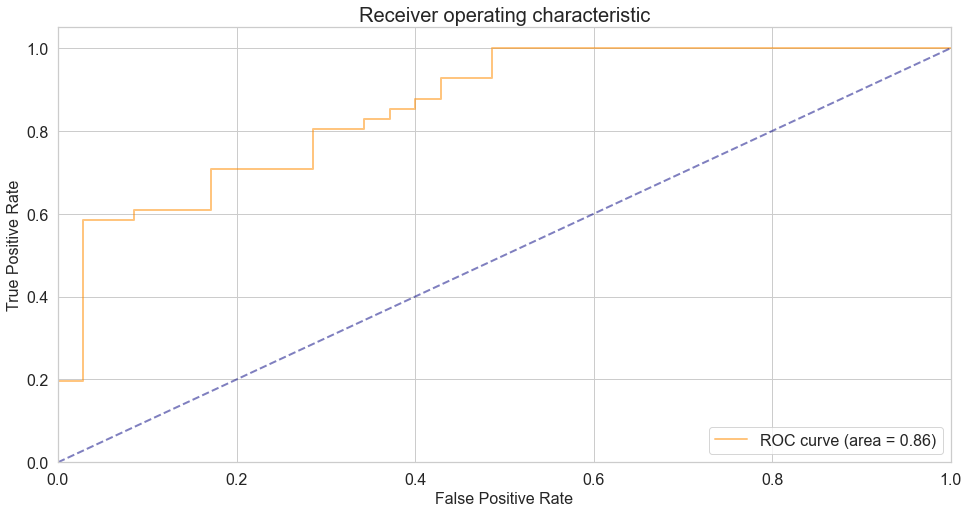

In [54]:
plt.figure(figsize=(16, 8))
lw = 2

plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc, alpha=0.5)

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--', alpha=0.5)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True)
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('Receiver operating characteristic', fontsize=20)
plt.legend(loc="lower right", fontsize=16)
plt.show()

Проанализируем False positive rate  и False negative rate

In [55]:
(thresholds, fpr) = get_fpr_curve(curve=curve)
(thresholds, fnr) = get_fnr_curve(curve=curve)

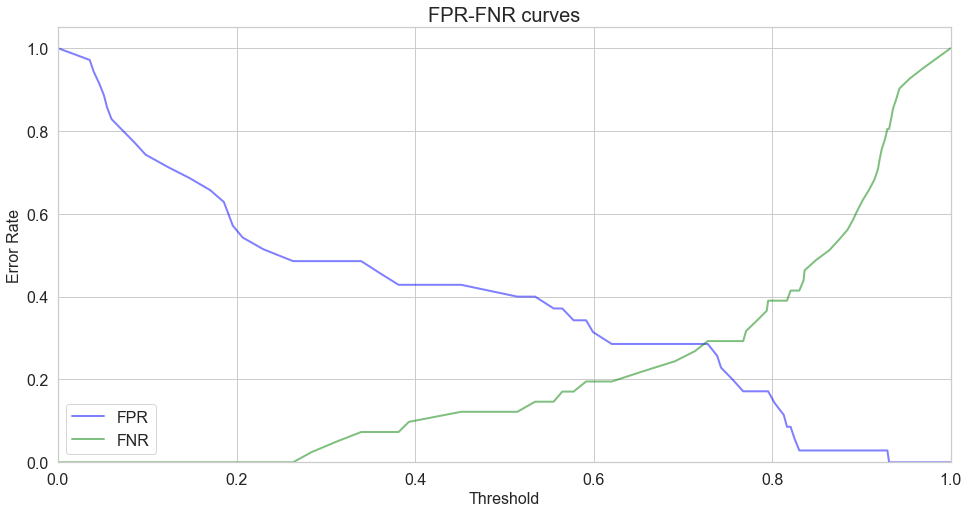

In [56]:
plt.figure(figsize=(16, 8))
lw = 2

plt.plot(thresholds, fpr, color='blue', lw=lw, label='FPR', alpha=0.5)
plt.plot(thresholds, fnr, color='green', lw=lw, label='FNR', alpha=0.5)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True)
plt.xlabel('Threshold', fontsize=16)
plt.ylabel('Error Rate', fontsize=16)
plt.title('FPR-FNR curves', fontsize=20)
plt.legend(loc="lower left", fontsize=16)
plt.show()

Выберем границу принятия решений, исходя из условий, что только 5% диагнозов могут пропустить наличие сердечно-сосудистых заболеваний.

In [57]:
threshold = round(select_threshold(model=model, data=eval_pool, FNR=0.05), 2)
threshold

0.31

Ожидаемый уровень ошибочных диагнозов ожидается на уровне 50 %, что является приемлемым. Так как окончательный диагноз будет ставиться только после дальнейшего глубокого анализа состояния пациента. 

Получим вероятности классов 

In [58]:
cat_prob = model.predict_proba(X=X_test)
cat_prob[:9]

array([[0.94835252, 0.05164748],
       [0.91218093, 0.08781907],
       [0.93823865, 0.06176135],
       [0.95886408, 0.04113592],
       [0.23386673, 0.76613327],
       [0.89155358, 0.10844642],
       [0.91569345, 0.08430655],
       [0.41053732, 0.58946268],
       [0.13940792, 0.86059208]])

Найдем предсказания диагноза пациента с учетом принятой выше границы принятия решений

In [59]:
cat_pred = list(map(lambda x: 1 if x[1] > 0.30 else 0, cat_prob))

In [60]:
cat_precision, cat_recall, cat_acc = get_metrics(y_test, cat_pred)

precision:  0.6964 
recall:  0.9512 
accuracy:  0.75


In [61]:
model.get_feature_importance(prettified=True)

,Feature Id,Importances
0,cp,20.803635
1,thal,18.016543
2,ca,12.276990
3,restecg,7.973437
4,thalach,6.750848
5,oldpeak,6.617351
6,exang,6.303137
7,trestbps,6.108114
8,slope,6.027393
9,chol,4.612900


Интересно, повышенный уровень сахара никак не влияет на постановку диагноза. Исходя что диагностирование здоровья человека очень индивидуальное мероприятие вожно посмотреть какие признаки сформировали данный диагноз. 

In [62]:
shap_values = model.get_feature_importance(eval_pool, type='ShapValues')

expected_value = shap_values[0,-1]
shap_values = shap_values[:,:-1]

print(shap_values.shape)

(76, 13)


In [63]:
shap.initjs()
shap.force_plot(expected_value, shap_values[2,:], raw_X.iloc[2,:])

Данный график позволяет сделать предсказания модели более прозрачными, и ответить пациенту на вполне закономерный вопрос: "Что же послужило причиной болезни?"

## Нейронная сеть

Не смотря на то что нейронные сети (НС) в большей степени подходят для работы с однородными данными, а датасет данного проекта относится к неоднородным, в порядке эксперимента все же попробуем реализовать полно связную НС небольшого размера, чтобы избежать "запоминания" тренировочной выборки.    

In [64]:
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)
torch.backends.cudnn.deterministic = True # при расчете на GPU детерминистичный режим быстрее

In [65]:
X_train_ohe, X_test_ohe, y_train, y_test = train_test_split(
X_ohe, y, test_size=0.25, random_state=42, stratify=y)

In [66]:
X_train_tensor = torch.FloatTensor(X_train_ohe.values)
X_test_tensor = torch.FloatTensor(X_test_ohe.values)
y_train_tensor = torch.LongTensor(y_train.values)
y_test_tensor = torch.LongTensor(y_test.values)

In [67]:
y_train_tensor

tensor([1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1,
        0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1,
        1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1,
        0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0,
        1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0,
        0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0,
        0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1,
        1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0,
        0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 0, 0, 1, 0, 0, 1, 1, 1, 1])

Выбирем архитектуру нейронной сети с двумя полносвязными слоями. Исходя из небольшой глубины НС в качестве функции активации выбирем сигмоиду. Так как НС решает задачу классификации в роли фунции потерь выбирем кросс энтропию.
В качестве алгоритма для градиентного спуска  - Adam как наиболее распространенный и универсальный/

In [68]:
class HeartNet(torch.nn.Module):
    def __init__(self, n_hidden_neurons):
        super(HeartNet, self).__init__()
        
        self.fc1 = torch.nn.Linear(30, n_hidden_neurons)
        self.activ1 = torch.nn.Sigmoid()
        self.fc2 = torch.nn.Linear(n_hidden_neurons, n_hidden_neurons)
        self.activ2 = torch.nn.Sigmoid()
        self.fc3 = torch.nn.Linear(n_hidden_neurons, 2)
        self.sm = torch.nn.Softmax(dim=1)
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.activ1(x)
        x = self.fc2(x)
        x = self.activ2(x)
        x = self.fc3(x)
        return x
# Так как в будущем хотим посчитать кросс энтропию в которой выходы прогоняются через ln
# а в софтмакс используется экспонента и е и ln, к-е взаимоуничтожаться
# и нам не нужно вычислять ln чтобы посчитать КЭ, т.о если хотим считать лоссы 
# кросс макс не нужен, а если считать вероятности то СМ нужен
# СМ долгая для вычисления и ее можно избежать
    def inference(self, x): # считаем вероятность
        x = self.forward(x)
        x = self.sm(x)
        return x

In [69]:
heart_net = HeartNet(7)
# 7 оптимально

In [70]:
loss = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(heart_net.parameters(), 
                             lr=1.0e-3)

Эксперементально выбирем оптимальное число эпох. Исходя из очень маленькой тренировочной выборки разбиение на батчи производиться не будет.

In [71]:
metric_history = []

In [72]:
epoch_num = 6000 # 6000
loss_history = [[0,0] for i in range(epoch_num)]

for epoch_index in range(epoch_num):
    optimizer.zero_grad() # Зануляем градиент

    y_pred = heart_net.forward(X_train_tensor)
    loss_val = loss(y_pred, y_train_tensor)
    
    loss_history[epoch_index][0] = epoch_index
    loss_history[epoch_index][1] = loss_val.data.numpy().tolist()    

    loss_val.backward()
    optimizer.step()
    
    nn_prob = heart_net.inference(X_test_tensor)
    nn_pred = list(map(lambda x: 1 if x[1] >= 0.5 else 0, nn_prob))
    metric_history.append(get_metrics(y_test, nn_pred, print_metrics = False))

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


In [73]:
metric_history

[(0.0, 0.0, 0.4605),
 (0.0, 0.0, 0.4605),
 (0.0, 0.0, 0.4605),
 (0.0, 0.0, 0.4605),
 (0.0, 0.0, 0.4605),
 (0.0, 0.0, 0.4605),
 (0.0, 0.0, 0.4605),
 (0.0, 0.0, 0.4605),
 (0.0, 0.0, 0.4605),
 (0.0, 0.0, 0.4605),
 (0.0, 0.0, 0.4605),
 (0.0, 0.0, 0.4605),
 (0.0, 0.0, 0.4605),
 (0.0, 0.0, 0.4605),
 (0.0, 0.0, 0.4605),
 (0.0, 0.0, 0.4605),
 (0.0, 0.0, 0.4605),
 (0.0, 0.0, 0.4605),
 (0.0, 0.0, 0.4605),
 (0.0, 0.0, 0.4605),
 (0.0, 0.0, 0.4605),
 (0.0, 0.0, 0.4605),
 (0.0, 0.0, 0.4605),
 (0.0, 0.0, 0.4605),
 (0.0, 0.0, 0.4605),
 (0.0, 0.0, 0.4605),
 (0.0, 0.0, 0.4605),
 (0.0, 0.0, 0.4605),
 (0.0, 0.0, 0.4605),
 (0.0, 0.0, 0.4605),
 (0.0, 0.0, 0.4605),
 (0.0, 0.0, 0.4605),
 (0.0, 0.0, 0.4605),
 (0.0, 0.0, 0.4605),
 (0.0, 0.0, 0.4605),
 (0.0, 0.0, 0.4605),
 (0.0, 0.0, 0.4605),
 (0.0, 0.0, 0.4605),
 (0.0, 0.0, 0.4605),
 (0.0, 0.0, 0.4605),
 (0.0, 0.0, 0.4605),
 (0.0, 0.0, 0.4605),
 (0.0, 0.0, 0.4605),
 (0.0, 0.0, 0.4605),
 (0.0, 0.0, 0.4605),
 (0.0, 0.0, 0.4605),
 (0.0, 0.0, 0.4605),
 (0.0, 0.0, 0

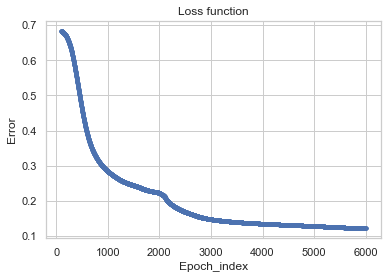

In [74]:
# При построении отсекается первые 100 значений,
# так как функция сначала имеет большие значения и начинает резко сходиться
plt.plot([row[0] for row in loss_history][100:], [row[1] for row in loss_history][100:], '.')
plt.title(label='Loss function')
plt.xlabel('Epoch_index')
plt.ylabel('Error');
plt.show()

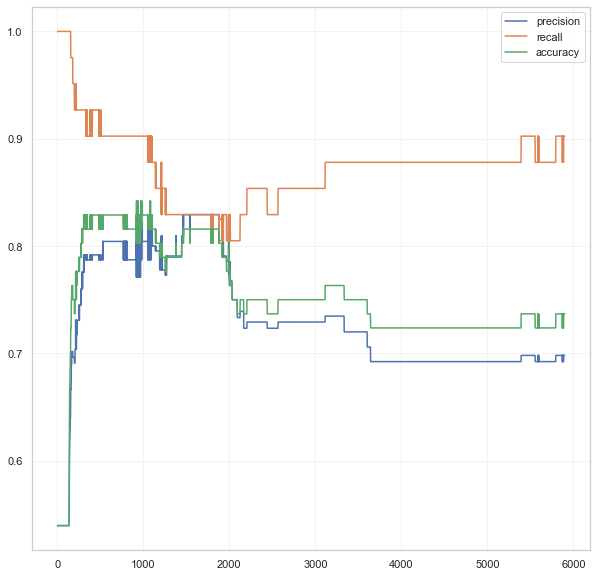

In [75]:
plt.figure(figsize = (10,10))
plt.plot(metric_history[100:])
plt.grid(color='0.95')
plt.legend(['precision','recall','accuracy'])

Расчитаем метрики полученной НС с изменением порога принятия решения

In [76]:
nn_prob = heart_net.inference(X_test_tensor)

In [77]:
nn_pred = list(map(lambda x: 1 if x[1] > 0.1 else 0, nn_prob))

In [78]:
nn_precision, nn_recall, nn_acc = get_metrics(y_test, nn_pred)

precision:  0.6964 
recall:  0.9512 
accuracy:  0.75


## Вывод

Для сравнения работы различных моделей, свеедм их метрики в единую таблицу.

In [79]:
resume = pd.DataFrame(
    {'Dummy': [dummy_precision, dummy_recall, dummy_acc],
    'Decision tree': [tree_precision, tree_recall, tree_acc],
    'CatBoost': [cat_precision, cat_recall, cat_acc],
    'NN': [nn_precision, nn_recall, nn_acc]},
    index = ['precision', 'recall', 'accuracy'])
resume

,dummy,decision tree,CatBoost,NN
precision,0.5395,0.7000,0.6964,0.6964
recall,1.0000,0.8537,0.9512,0.9512
accuracy,0.5395,0.7237,0.7500,0.7500


Вспомним что Decision Tree в данном исследования является симуляцией алгоритма, согласно которому врач ставит диагноз пациенту. Эта модель имеет предельно ясную интерпретацию своей работы в виде дерева решений. Работоспособность этой модели показана на примере сравнения с Dummy моделью.
Далее рассмотрены "боевые" модели нейронной сети и CatBoost, которые могут иметь практическое применение:
Метрики качества НС равны модели CatBoost, что говорит о максимальном пороге точности которой достижим на столь ограниченной выборке. Т.е. ошибка заложена не в найденной закономерности, а в самих исходных данных тренировочной выборки. Это можно объяснить небольшим размером этой выборки, а следовательно, не все возможные варианты взаимосвязей были в ней представлены. Дальнейшее повышение точности работы модели возможно с расширением базы данных. На текущем этапе разработке рекомендуется модель CatBoost, так как данная модель имеет ряд методов позволяющие сделать ее работу более прозрачной и выделить ряд ключевых признаков, повлиявших на принятие решения, что будет важным сведением для пациента.